## MACHINE LEARNING MODEL -  IROHACK PROJECT 

### STEP 1: LOAD LIBRARYS

In [50]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tabulate import tabulate


### STEP 2: LOAD DATASET 

In [51]:

# Load the already combined dataset (TradeVision)
TradeVision = pd.read_csv(r"D:\Project\TradeVision\Data\Combined_Stock_Data.csv")

# Show the first few rows to confirm the data is loaded correctly
print("📊 First Few Rows of Combined Stock Data:")
print(tabulate(TradeVision.head(), headers='keys', tablefmt='grid'))

# Ensure 'Date' column is in datetime format
TradeVision['Date'] = pd.to_datetime(TradeVision['Date'], dayfirst=True)



📊 First Few Rows of Combined Stock Data:
+----+------------+-----------+----------+--------------+--------------+-------------+---------------+-------------+-----------------------+-----------+-------------+-------------+--------------+------------+-------------+-------------+--------------+------------+----------+
|    | Date       | Company   | Ticker   |   Open_Price |   High_Price |   Low_Price |   Close_Price |   Adj_Close |   Daily_Price_Changes |    Volume |   MA_10days |   MA_50days |   MA_200days |      Gains |      Losses |   Avg_Gains |   Avg_Losses |         RS |      RSI |
+====+============+===========+==========+==============+==============+=============+===============+=============+=======================+===========+=============+=============+==============+============+=============+=============+==============+============+==========+
|  0 | 02/01/2019 | Apple     | AAPL     |      36.9445 |      37.889  |     36.787  |       37.6672 |     41.4339 |            -4.

### STEP 3: CLEANIG THE DATASET

In [52]:
# Set display option for a limited number of rows
pd.set_option('display.max_rows', 100)

# Check for missing values
print("\n🚨 Missing Data:")
print(tabulate(TradeVision.isnull().sum().reset_index(), headers=['Column', 'Missing Values'], tablefmt='grid'))

# Display basic statistics of the dataset with a limit on number of rows
print("\n📊 Basic Statistics of Combined Data:")
print(tabulate(TradeVision.describe().head(20).reset_index(), headers='keys', tablefmt='grid'))  # Adjusted to show only the first 20 rows

# Fill missing 'Company' values with 'Unknown'
TradeVision['Company'] = TradeVision['Company'].fillna('Unknown')

# Forward fill missing values across the whole DataFrame
TradeVision = TradeVision.ffill()

# Check again for missing values
print("\n🚨 Missing Data After Fixing:")
print(tabulate(TradeVision.isnull().sum().reset_index(), headers=['Column', 'Missing Values'], tablefmt='grid'))



🚨 Missing Data:
+----+---------------------+------------------+
|    | Column              |   Missing Values |
+====+=====================+==================+
|  0 | Date                |                0 |
+----+---------------------+------------------+
|  1 | Company             |                0 |
+----+---------------------+------------------+
|  2 | Ticker              |                0 |
+----+---------------------+------------------+
|  3 | Open_Price          |                0 |
+----+---------------------+------------------+
|  4 | High_Price          |                0 |
+----+---------------------+------------------+
|  5 | Low_Price           |                0 |
+----+---------------------+------------------+
|  6 | Close_Price         |                0 |
+----+---------------------+------------------+
|  7 | Adj_Close           |                0 |
+----+---------------------+------------------+
|  8 | Daily_Price_Changes |                0 |
+----+-----------------

### STEP 3.1: CREATE COLUMNS

In [53]:
import numpy as np
import pandas as pd

# Drop existing columns (if they exist)
cols_to_drop = ['Gains', 'Losses', 'Avg_Gains', 'Avg_Losses', 'RS', 'RSI']
TradeVision = TradeVision.drop(columns=[col for col in cols_to_drop if col in TradeVision], errors='ignore')

# Recreate the moving averages
TradeVision['MA_10days'] = TradeVision.groupby('Company')['Adj_Close'].transform(lambda x: x.rolling(window=10).mean())
TradeVision['MA_50days'] = TradeVision.groupby('Company')['Adj_Close'].transform(lambda x: x.rolling(window=50).mean())
TradeVision['MA_200days'] = TradeVision.groupby('Company')['Adj_Close'].transform(lambda x: x.rolling(window=200).mean())


# Calculate daily price change
TradeVision['Price Change'] = TradeVision['Adj_Close'].diff()

# Calculate Gains and Losses
TradeVision['Gains'] = TradeVision['Price Change'].clip(lower=0)  # Only keep positive values
TradeVision['Losses'] = -TradeVision['Price Change'].clip(upper=0)  # Only keep negative values, make them positive

# Define RSI period (standard is 14 days)
window = 14

# Calculate rolling averages of gains and losses
TradeVision['Avg_Gains'] = TradeVision['Gains'].rolling(window=window, min_periods=1).mean()
TradeVision['Avg_Losses'] = TradeVision['Losses'].rolling(window=window, min_periods=1).mean()

# Compute Relative Strength (RS)
TradeVision['RS'] = TradeVision['Avg_Gains'] / TradeVision['Avg_Losses'].replace(0, np.nan)

# Compute RSI
TradeVision['RSI'] = 100 - (100 / (1 + TradeVision['RS']))

# Drop unnecessary columns
TradeVision.drop(columns=['Price Change', 'Daily_Price_Changes'], inplace=True)

# Display first few rows after renaming
print("\n📊 First Few Rows After Renaming Moving Averages:")
print(tabulate(TradeVision.head(), headers='keys', tablefmt='grid'))


📊 First Few Rows After Renaming Moving Averages:
+----+---------------------+-----------+----------+--------------+--------------+-------------+---------------+-------------+-----------+-------------+-------------+--------------+------------+-------------+-------------+--------------+------------+----------+
|    | Date                | Company   | Ticker   |   Open_Price |   High_Price |   Low_Price |   Close_Price |   Adj_Close |    Volume |   MA_10days |   MA_50days |   MA_200days |      Gains |      Losses |   Avg_Gains |   Avg_Losses |         RS |      RSI |
+====+=====================+===========+==========+==============+==============+=============+===============+=============+===========+=============+=============+==============+============+=============+=============+==============+============+==========+
|  0 | 2019-01-02 00:00:00 | Apple     | AAPL     |      36.9445 |      37.889  |     36.787  |       37.6672 |     41.4339 | 148158800 |         nan |         nan |  

#### STEP 3.2: CONVERT DATA TYPE

In [54]:
# Remove duplicate 'Date' column if it exists
TradeVision = TradeVision.loc[:, ~TradeVision.columns.duplicated()]

# Convert 'Date' column to datetime and set as index
TradeVision['Date'] = pd.to_datetime(TradeVision['Date'], errors='coerce')
TradeVision.set_index('Date', inplace=True)

# Display first few rows
print("\n📊 First Few Rows After Renaming Moving Averages:")
print(tabulate(TradeVision.head(), headers='keys', tablefmt='grid'))




📊 First Few Rows After Renaming Moving Averages:
+---------------------+-----------+----------+--------------+--------------+-------------+---------------+-------------+-----------+-------------+-------------+--------------+------------+-------------+-------------+--------------+------------+----------+
| Date                | Company   | Ticker   |   Open_Price |   High_Price |   Low_Price |   Close_Price |   Adj_Close |    Volume |   MA_10days |   MA_50days |   MA_200days |      Gains |      Losses |   Avg_Gains |   Avg_Losses |         RS |      RSI |
+=====================+===========+==========+==============+==============+=============+===============+=============+===========+=============+=============+==============+============+=============+=============+==============+============+==========+
| 2019-01-02 00:00:00 | Apple     | AAPL     |      36.9445 |      37.889  |     36.787  |       37.6672 |     41.4339 | 148158800 |         nan |         nan |          nan | nan   

#### STEP 3.3: NORMALIZE THE DATA

In [55]:

# Initialize the MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Select columns to normalize
columns_to_normalize = ['Open_Price', 'High_Price', 'Low_Price', 'Close_Price', 'Adj_Close', 'Volume']

# Apply the scaler to the selected columns
TradeVision[columns_to_normalize] = scaler.fit_transform(TradeVision[columns_to_normalize])

# Display Normalized Data
print("\n📊 First Few Rows After Normalization:")
print(tabulate(TradeVision.head(), headers='keys', tablefmt='grid'))



📊 First Few Rows After Normalization:
+---------------------+-----------+----------+--------------+--------------+-------------+---------------+-------------+-----------+-------------+-------------+--------------+------------+-------------+-------------+--------------+------------+----------+
| Date                | Company   | Ticker   |   Open_Price |   High_Price |   Low_Price |   Close_Price |   Adj_Close |    Volume |   MA_10days |   MA_50days |   MA_200days |      Gains |      Losses |   Avg_Gains |   Avg_Losses |         RS |      RSI |
+=====================+===========+==========+==============+==============+=============+===============+=============+===========+=============+=============+==============+============+=============+=============+==============+============+==========+
| 2019-01-02 00:00:00 | Apple     | AAPL     |    0.0729558 |    0.0745587 |   0.0731625 |     0.0745617 |   0.0745617 | 0.0562995 |         nan |         nan |          nan | nan        | nan 

#### STEP 3.4: CHECKING THE DATA TYPE

In [56]:
# Check the updated data types without resetting the index
print("\nTradeVision:")
print(tabulate(TradeVision.dtypes.items(), headers=['Column', 'Data Type'], tablefmt='grid'))



TradeVision:
+-------------+-------------+
| Column      | Data Type   |
+=============+=============+
| Company     | object      |
+-------------+-------------+
| Ticker      | object      |
+-------------+-------------+
| Open_Price  | float64     |
+-------------+-------------+
| High_Price  | float64     |
+-------------+-------------+
| Low_Price   | float64     |
+-------------+-------------+
| Close_Price | float64     |
+-------------+-------------+
| Adj_Close   | float64     |
+-------------+-------------+
| Volume      | float64     |
+-------------+-------------+
| MA_10days   | float64     |
+-------------+-------------+
| MA_50days   | float64     |
+-------------+-------------+
| MA_200days  | float64     |
+-------------+-------------+
| Gains       | float64     |
+-------------+-------------+
| Losses      | float64     |
+-------------+-------------+
| Avg_Gains   | float64     |
+-------------+-------------+
| Avg_Losses  | float64     |
+-------------+-----------

### STEP 4: CREATE A SEQUENCE FOR LSTM

In [57]:
# Function to create sequences for LSTM
def create_sequences(data, sequence_length):
    sequences = []
    labels = []
    
    for i in range(len(data) - sequence_length):
        sequence = data[i:i+sequence_length]
        label = data[i+sequence_length, 3]  # Predict the 'Close_Price' (index 3)
        sequences.append(sequence)
        labels.append(label)
    
    return np.array(sequences), np.array(labels)

# Define sequence length (e.g., 60 time steps)
sequence_length = 60

# Get sequences and labels
sequences, labels = create_sequences(TradeVision[columns_to_normalize].values, sequence_length)

# Reshape sequences for LSTM (samples, time steps, features)
sequences = sequences.reshape(sequences.shape[0], sequences.shape[1], len(columns_to_normalize))

# Display the shape of sequences and labels

shapes_data = [['Sequences', sequences.shape], ['Labels', labels.shape]]
print(tabulate(shapes_data, headers=['Data', 'Shape'], tablefmt='grid'))


+-----------+---------------+
| Data      | Shape         |
+===========+===============+
| Sequences | (6034, 60, 6) |
+-----------+---------------+
| Labels    | (6034,)       |
+-----------+---------------+


#### STEP 4.1: SPLIT THE DATA INTO TRAINING AND TESTING SETS

In [58]:
from sklearn.model_selection import train_test_split

# Split the sequences and labels into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(sequences, labels, test_size=0.2, shuffle=False)

# Print the shapes of the splits in a tabulated format
data_split = [
    ['X_train', X_train.shape],
    ['X_test', X_test.shape],
    ['y_train', y_train.shape],
    ['y_test', y_test.shape]
]

print(tabulate(data_split, headers=['Type', 'Shape'], tablefmt='grid'))


+---------+---------------+
| Type    | Shape         |
+=========+===============+
| X_train | (4827, 60, 6) |
+---------+---------------+
| X_test  | (1207, 60, 6) |
+---------+---------------+
| y_train | (4827,)       |
+---------+---------------+
| y_test  | (1207,)       |
+---------+---------------+


### STEP 5: BUILD THE LSTM MODEL

In [59]:
# Define the TradeVisionLSTM model
def TradeVisionLSTM(input_shape):
    model = Sequential()

    # Add LSTM layers
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))

    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))

    # Add output layer
    model.add(Dense(units=1))

    # Compile the model
    model.compile(optimizer=Adam(), loss='mean_squared_error')

    return model

# Assuming X_train is already defined and has the shape (samples, timesteps, features)
input_shape = (X_train.shape[1], X_train.shape[2])
model = TradeVisionLSTM(input_shape)

# Model summary in tabulate format
model_summary = [
    ['Layer Type', 'Details'],
    ['Input Layer', f'Input(shape=({input_shape[0]}, {input_shape[1]}))'],
    ['LSTM Layer 1', 'LSTM(units=50, return_sequences=True)'],
    ['Dropout Layer 1', 'Dropout(0.2)'],
    ['LSTM Layer 2', 'LSTM(units=50, return_sequences=False)'],
    ['Dropout Layer 2', 'Dropout(0.2)'],
    ['Dense Layer', 'Dense(units=1)'],
    ['Optimizer', 'Adam'],
    ['Loss Function', 'Mean Squared Error']
]

# Print the model summary
print(tabulate(model_summary, headers='firstrow', tablefmt='grid'))



+-----------------+----------------------------------------+
| Layer Type      | Details                                |
+=================+========================================+
| Input Layer     | Input(shape=(60, 6))                   |
+-----------------+----------------------------------------+
| LSTM Layer 1    | LSTM(units=50, return_sequences=True)  |
+-----------------+----------------------------------------+
| Dropout Layer 1 | Dropout(0.2)                           |
+-----------------+----------------------------------------+
| LSTM Layer 2    | LSTM(units=50, return_sequences=False) |
+-----------------+----------------------------------------+
| Dropout Layer 2 | Dropout(0.2)                           |
+-----------------+----------------------------------------+
| Dense Layer     | Dense(units=1)                         |
+-----------------+----------------------------------------+
| Optimizer       | Adam                                   |
+-----------------+-----

d:\Project\TradeVision\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


#### STEP 5.1: TRAINING THE MODEL  

In [26]:
# EarlyStopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train, 
    epochs=50, 
    batch_size=32, 
    validation_split=0.2,
    callbacks=[early_stopping]
)


Epoch 1/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - loss: 0.0141 - val_loss: 0.0083
Epoch 2/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0019 - val_loss: 0.0046
Epoch 3/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0013 - val_loss: 0.0046
Epoch 4/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0012 - val_loss: 0.0041
Epoch 5/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0011 - val_loss: 0.0037
Epoch 6/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0010 - val_loss: 0.0035
Epoch 7/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 9.6707e-04 - val_loss: 0.0033
Epoch 8/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 8.7632e-04 - val_loss: 0.0038
Epoch 9/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 7.6799e-04 - val_loss: 0.0031
Epoch 10/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 7.5324e-04 - val_loss: 0.0029
Epoch 11/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 7.9759e-04 - val_loss: 0.0029
Epoch 12/50
121/121 

### STEP 5.2: PREDICTING THE STOCK PRICES USING THE TEST DATA

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


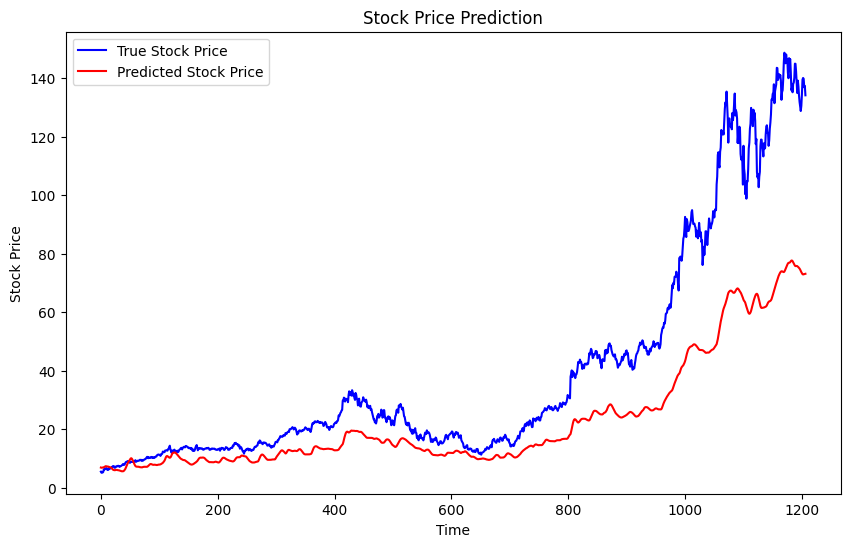

In [60]:
# Predicting the stock prices using the model
predictions = model.predict(X_test)

# Reshape predictions to match the scaler's expected input shape
predictions = predictions.reshape(-1, 1)
# Ensure the scaler inverse transform matches the original shape, i.e., 6 features
predictions_actual = scaler.inverse_transform(np.hstack((predictions, np.zeros((predictions.shape[0], 5)))))[:, 0]

# Inverse transform the actual values of y_test to get them back to the original scale
y_test_actual = scaler.inverse_transform(np.hstack((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], 5)))))[:, 0]

# Plotting the predicted vs true values
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual, color='blue', label='True Stock Price')
plt.plot(predictions_actual, color='red', label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


### STEP 5.2: PREDICTING THE STOCK PRICES FOR EACH COMPANY

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


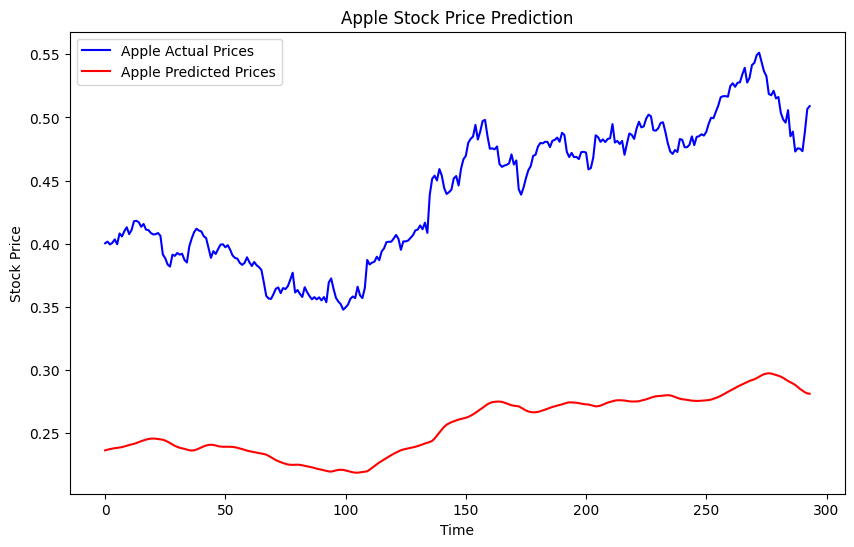

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


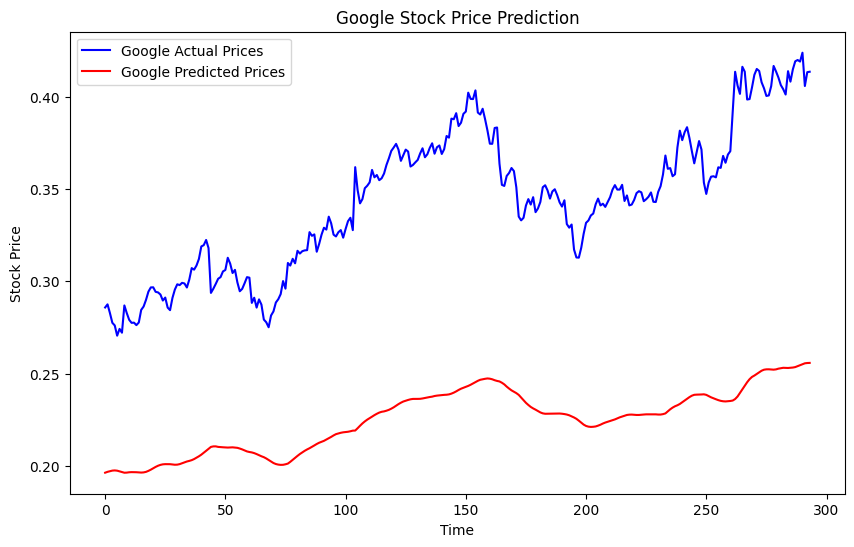

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


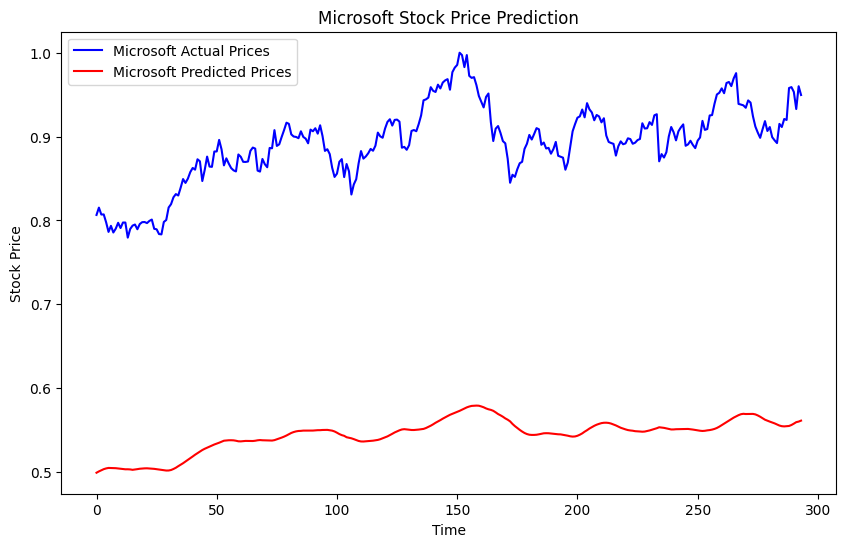

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


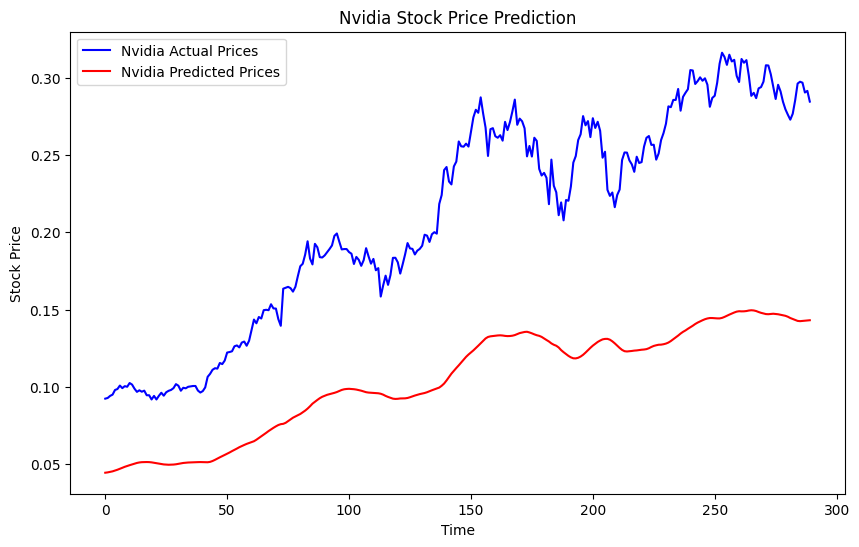

In [61]:
# Filter the dataset by company and ticker
companies = TradeVision['Company'].unique()

def create_sequences(data, sequence_length):
    sequences = []
    labels = []
    
    for i in range(len(data) - sequence_length):
        sequence = data[i:i+sequence_length]
        label = data[i+sequence_length, 3]  # We just need the next Close_Price
        sequences.append(sequence)
        labels.append(label)
    
    return np.array(sequences), np.array(labels)


for company in companies:
    # Filter data for each company
    company_data = TradeVision[TradeVision['Company'] == company]

    # Scaling and preprocessing steps
    scaler = MinMaxScaler(feature_range=(0, 1))
    company_data_scaled = scaler.fit_transform(company_data[columns_to_normalize])
    
    # Prepare data for training/testing
    X, y = create_sequences(company_data_scaled, sequence_length)  # Use the create_sequences function

    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    
    # Reshape X_test to match the input shape of the model
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], len(columns_to_normalize))
    
    # Use the pre-existing model to make predictions
    predictions = model.predict(X_test)
    
    # Inverse transform predictions and actual values
    zero_padding = np.zeros((predictions.shape[0], len(columns_to_normalize) - 1))
    predictions_actual = scaler.inverse_transform(np.hstack((predictions, zero_padding)))[:, 0]
    zero_padding = np.zeros((y_test.shape[0], len(columns_to_normalize) - 1))
    y_test_actual = scaler.inverse_transform(np.hstack((y_test.reshape(-1, 1), zero_padding)))[:, 0]

    # Plotting the results
    plt.figure(figsize=(10, 6))
    plt.plot(y_test_actual, color='blue', label=f'{company} Actual Prices')
    plt.plot(predictions_actual, color='red', label=f'{company} Predicted Prices')
    plt.title(f'{company} Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()


### STEP 5.3: PERFORMANCE CALCULATION FOR ALL COMPANIES

In [62]:
from sklearn.metrics import mean_absolute_error

# Initialize an empty list to store performance data for all companies
all_performance_data = []

# Loop through each company and calculate performance metrics
for company in companies:
    # Filter data for the current company
    company_data = TradeVision[TradeVision['Company'] == company]

    # Scaling and preprocessing steps
    company_data_scaled = scaler.fit_transform(company_data[columns_to_normalize])

    # Prepare data for training/testing
    X, y = create_sequences(company_data_scaled, sequence_length)

    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # Use the pre-existing model to make predictions
    predictions = model.predict(X_test)

    # Inverse transform predictions and actual values
    predictions_actual = scaler.inverse_transform(np.hstack((predictions, np.zeros((predictions.shape[0], len(columns_to_normalize) - 1)))))[:, 0]
    y_test_actual = scaler.inverse_transform(np.hstack((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], len(columns_to_normalize) - 1)))))[:, 0]

    # Calculate performance metrics
    mse = mean_squared_error(y_test_actual, predictions_actual)
    mae = mean_absolute_error(y_test_actual, predictions_actual)
    r2 = r2_score(y_test_actual, predictions_actual)

    # Append performance metrics to the all_performance_data list
    all_performance_data.append([company, mse, mae, r2])

# Print performance metrics for all companies in a tabulated format
print(tabulate(all_performance_data, headers=["Company", "MSE", "MAE", "R²"], tablefmt="fancy_grid"))


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
╒═══════════╤═══════════╤══════════╤═══════════╕
│ Company   │       MSE │      MAE │        R² │
╞═══════════╪═══════════╪══════════╪═══════════╡
│ Apple     │ 0.0348362 │ 0.183839 │ -10.9372  │
├───────────┼───────────┼──────────┼───────────┤
│ Google    │ 0.0146972 │ 0.118913 │  -8.6432  │
├───────────┼───────────┼──────────┼───────────┤
│ Microsoft │ 0.121634  │ 0.347346 │ -54.6681  │
├───────────┼───────────┼──────────┼───────────┤
│ Nvidia    │ 0.0126097 │ 0.105929 │  -1.58545 │
╘═══════════╧═══════════╧══════════╧═══════════╛


In [70]:
len(company_data)

4

In [69]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Choose the company you are interested in
company = "MSFT"  # Example for MSFT, change accordingly

# Filter data for the selected company
company_data = TradeVision[TradeVision['Ticker'] == company]

# Scaling and preprocessing
scaler = MinMaxScaler(feature_range=(0, 1))
company_data_scaled = scaler.fit_transform(company_data[['Close_Price']])

sequence_length = 30  # or any other number based on your data and model
future_days = 10  # For example, predicting 10 days ahead

# Ensure there is enough data for the sequence length
if len(company_data_scaled) < sequence_length:
    raise ValueError(f"Not enough data to create a sequence of length {sequence_length}")

# Use the most recent data (last sequence) for prediction
recent_data = company_data_scaled[-sequence_length:]

# Initialize list to store predictions
future_predictions = []

# Predict future prices iteratively
for i in range(future_days):
    # Reshape the input for the model
    recent_data_reshaped = recent_data.reshape(1, sequence_length, 1)  # Reshape correctly
    
    # Predict the next value
    predicted_price = model.predict(recent_data_reshaped)
    
    # Store prediction
    future_predictions.append(predicted_price[0][0])
    
    # Update the recent data with the new prediction
    recent_data = np.append(recent_data[1:], predicted_price, axis=0).reshape(sequence_length, 1)

# Inverse transform the predicted values
future_predictions_actual = scaler.inverse_transform(np.hstack((np.array(future_predictions).reshape(-1, 1), np.zeros((len(future_predictions), 5)))))[:, 0]

# Plot the future predictions
plt.figure(figsize=(10, 6))
plt.plot(future_predictions_actual, color='green', label=f'{company} Predicted Future Prices')
plt.title(f'{company} Future Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()



ValueError: Not enough data to create a sequence of length 30

In [40]:
print(company_data.columns)


Index(['Company', 'Ticker', 'Open_Price', 'High_Price', 'Low_Price',
       'Close_Price', 'Adj_Close', 'Volume', 'MA_10days', 'MA_50days',
       'MA_200days', 'Gains', 'Losses', 'Avg_Gains', 'Avg_Losses', 'RS',
       'RSI'],
      dtype='object')


### SAVE THE MODEL

In [ ]:
# Save the trained model
model.save('TradeVisionLSTM.keras')


### SAVE THE DATASET CSV FILE

In [48]:
TradeVision.to_csv(r"D:\Project\TradeVision\Data\Combined_Stock_Data.csv", index=False)
print("\n📁 Combined stock data saved as 'Combined_Stock_Data.csv'.")


📁 Combined stock data saved as 'Combined_Stock_Data.csv'.
